# Programming for Business - Project 1
## Exploritory Data Analysis

In [50]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter

sns.set_theme(style="whitegrid")

In [51]:
DATA_PATH = "realtor-data.csv"

df = pd.read_csv(DATA_PATH)

print(f"Data frame head: \n {df.head()}")
print(f"Dataframe describe: \n {df.describe()}")
print(f"Dataframe info: \n {df.info()}")

Data frame head: 
    brokered_by    status     price  bed  bath  acre_lot     street  \
0     103378.0  for_sale  105000.0  3.0   2.0      0.12  1962661.0   
1      52707.0  for_sale   80000.0  4.0   2.0      0.08  1902874.0   
2     103379.0  for_sale   67000.0  2.0   1.0      0.15  1404990.0   
3      31239.0  for_sale  145000.0  4.0   2.0      0.10  1947675.0   
4      34632.0  for_sale   65000.0  6.0   2.0      0.05   331151.0   

         city        state  zip_code  house_size prev_sold_date  
0    Adjuntas  Puerto Rico     601.0       920.0            NaN  
1    Adjuntas  Puerto Rico     601.0      1527.0            NaN  
2  Juana Diaz  Puerto Rico     795.0       748.0            NaN  
3       Ponce  Puerto Rico     731.0      1800.0            NaN  
4    Mayaguez  Puerto Rico     680.0         NaN            NaN  
Dataframe describe: 
         brokered_by         price           bed          bath      acre_lot  \
count  2.221849e+06  2.224841e+06  1.745065e+06  1.714611e+06  

In [52]:
df.columns

Index(['brokered_by', 'status', 'price', 'bed', 'bath', 'acre_lot', 'street',
       'city', 'state', 'zip_code', 'house_size', 'prev_sold_date'],
      dtype='object')

In [53]:
target_col = "price"

row_count, col_count = df.shape
numeric_features = df.select_dtypes(include=["number"]).columns.tolist()
non_numeric_features = df.select_dtypes(exclude=["number"]).columns.tolist()
descriptive_features = [col for col in df.columns if col != target_col]

print("Dataset Overview")
print("-----------------")
print(f"Rows: {row_count}")
print(f"Columns: {col_count}")
print(f"Target Feature: {target_col} ({df[target_col].dtype})")
print(f"Descriptive Features ({len(descriptive_features)}): {descriptive_features}")
print(f"Numeric Features ({len(numeric_features)}): {numeric_features}")
print(f"Non-numeric Features ({len(non_numeric_features)}): {non_numeric_features}")

feature_summary = df[descriptive_features].dtypes.to_frame(name="dtype")
feature_summary["missing_count"] = df[descriptive_features].isna().sum()
feature_summary["unique_values"] = df[descriptive_features].nunique()
feature_summary

Dataset Overview
-----------------
Rows: 2226382
Columns: 12
Target Feature: price (float64)
Descriptive Features (11): ['brokered_by', 'status', 'bed', 'bath', 'acre_lot', 'street', 'city', 'state', 'zip_code', 'house_size', 'prev_sold_date']
Numeric Features (8): ['brokered_by', 'price', 'bed', 'bath', 'acre_lot', 'street', 'zip_code', 'house_size']
Non-numeric Features (4): ['status', 'city', 'state', 'prev_sold_date']


,dtype,missing_count,unique_values
brokered_by,float64,4533,110143
status,object,0,3
bed,float64,481317,99
bath,float64,511771,86
acre_lot,float64,325589,16057
street,float64,10866,2001358
city,object,1407,20098
state,object,8,55
zip_code,float64,299,30334
house_size,float64,568484,12061


### Step 1: Get to Know the Data
The table above lists the target column (`price`), counts how many rows/columns we have, and summarizes the types of features available. This lines up with the project requirement to document the descriptive features and the target feature.

In [54]:
price_bins = pd.qcut(df[target_col], q=4, labels=["Q1: Lowest", "Q2", "Q3", "Q4: Highest"], duplicates="drop")

summary_features = [col for col in numeric_features if col not in {target_col, "zip_code", "street", "brokered_by"}]
quartile_summary = (
    df.groupby(price_bins, observed=False)[summary_features]
    .agg(['median', 'mean'])
    .round(2)
)
quartile_summary

bed         bath       acre_lot        house_size         
            median  mean median  mean   median   mean     median     mean
price                                                                    
Q1: Lowest     3.0  2.69    2.0  1.60     0.39  13.33     1192.0  5947.80
Q2             3.0  2.99    2.0  2.10     0.24  13.16     1517.0  1638.93
Q3             3.0  3.33    2.0  2.54     0.22  10.89     1917.0  2035.67
Q4: Highest    4.0  3.79    3.0  3.30     0.27  23.59     2469.0  2931.60

In [55]:
missing_summary = (
    df.isna()
    .sum()
    .to_frame(name="missing_count")
    .assign(missing_pct=lambda x: (x["missing_count"] / len(df) * 100).round(2))
    .sort_values("missing_count", ascending=False)
)
missing_summary

,missing_count,missing_pct
prev_sold_date,734297,32.98
house_size,568484,25.53
bath,511771,22.99
bed,481317,21.62
acre_lot,325589,14.62
street,10866,0.49
brokered_by,4533,0.20
price,1541,0.07
city,1407,0.06
zip_code,299,0.01


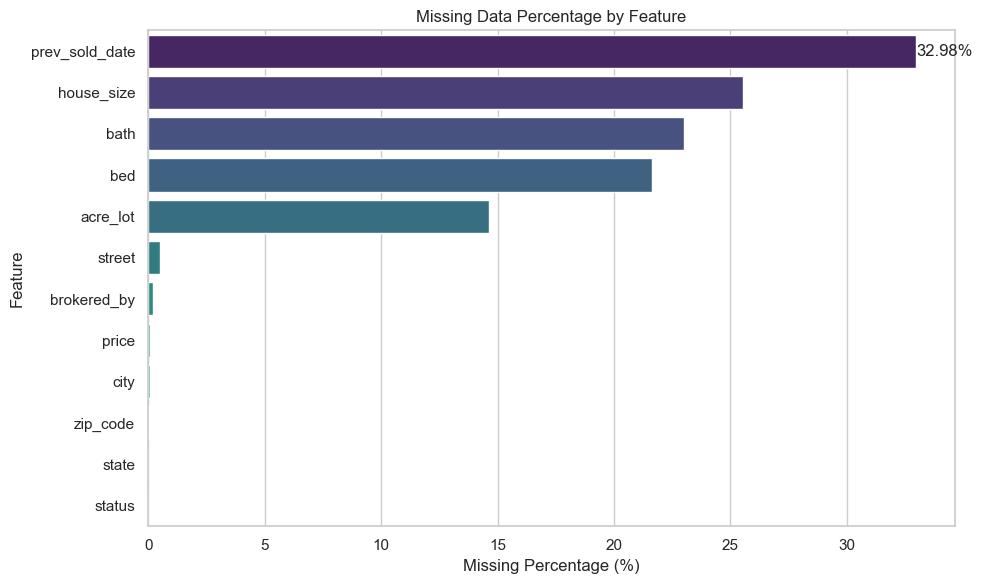

In [56]:
fig, ax = plt.subplots(figsize=(10, 6))
plot_data = missing_summary.reset_index().rename(columns={"index": "feature"})
sns.barplot(data=plot_data, x="missing_pct", y="feature", hue="feature", ax=ax, palette="viridis", legend=False)
ax.set_title("Missing Data Percentage by Feature")
ax.set_xlabel("Missing Percentage (%)")
ax.set_ylabel("Feature")
ax.bar_label(ax.containers[0], fmt="%.2f%%")
plt.tight_layout()
plt.show()

### Step 2: Check Missing Data
`bed`, `bath`, `house_size`, and `acre_lot` have noticeable gaps, while the rest are mostly complete. For this intro project I fill numeric gaps with the overall median so we can keep most rows, but I **drop any listings missing key categorical info (`status`, `city`, `state`, or `brokered_by`)** because guessing those would change the business meaning. The plot helps highlight where the missing values live.

Another option would be to just remove all rows with missing values. While we'd lose lots of data, we have millions of records so we could still complete the project. 

### Step 4: Explore Feature Distributions
With the cleaned table ready, these histograms and boxplots show how each numeric feature is spread out and how many outliers we trimmed for clarity. This addresses the requirement to study distributions and highlight potential outliers.

In [ ]:
# Visualize distributions for numerical features using the processed dataset
numeric_to_plot = ["price", "bed", "bath", "acre_lot", "house_size"]

plot_rows = len(numeric_to_plot)
fig, axes = plt.subplots(plot_rows, 2, figsize=(14, 4 * plot_rows))
axes = np.atleast_2d(axes)

for idx, col in enumerate(numeric_to_plot):
    series = processed_df[col].dropna()
    if series.empty:
        continue

    lower = series.quantile(0.01)
    upper = series.quantile(0.99)
    trimmed = series[(series >= lower) & (series <= upper)]
    outlier_pct = 100 * (len(series) - len(trimmed)) / len(series)

    sns.histplot(trimmed, ax=axes[idx, 0], kde=True, bins=40, color="#1f77b4")
    axes[idx, 0].set_title(f"Distribution of {col} (1st-99th pct)")
    axes[idx, 0].set_xlabel(col)
    axes[idx, 0].ticklabel_format(style="plain", axis="x")

    sns.boxplot(x=trimmed, ax=axes[idx, 1], color="#ff7f0e", orient="h")
    axes[idx, 1].set_title(f"Boxplot of {col} (trimmed)")
    axes[idx, 1].set_xlabel(col)
    axes[idx, 1].ticklabel_format(style="plain", axis="x")
    axes[idx, 1].text(
        0.98,
        0.85,
        f"Outliers removed: {outlier_pct:.1f}%",
        transform=axes[idx, 1].transAxes,
        ha="right",
        fontsize=9,
        color="#555555",
    )

    if col == "price":
        formatter = FuncFormatter(currency_label)
        axes[idx, 0].xaxis.set_major_formatter(formatter)
        axes[idx, 1].xaxis.set_major_formatter(formatter)
    elif col in {"acre_lot"}:
        axes[idx, 0].xaxis.set_major_formatter(FuncFormatter(lambda x, _pos: f"{x:.1f}" if x < 10 else f"{x:,.0f}"))
        axes[idx, 1].xaxis.set_major_formatter(FuncFormatter(lambda x, _pos: f"{x:.1f}" if x < 10 else f"{x:,.0f}"))

plt.tight_layout()
plt.show()

### Step 3: Basic Cleaning
To keep things simple, I do all of the structural cleanup in one place. First I drop any listings that are missing `status`, `city`, `state`, `zip_code`, or `brokered_by` so I do not have to guess that business-critical info. 

Right after that I completely remove the `prev_sold_date` column because one-third of the rows are missing it and the value does not explain current prices very well. 

Keeping these steps bundled together makes it clear what was changed before building the remaining visuals.

In [ ]:
categorical_cols = ["status", "city", "state", "brokered_by", "zip_code"]
processed_df = df.dropna(subset=categorical_cols).copy()

# Remove the sparse previous sale timestamp entirely
processed_df = processed_df.drop(columns=["prev_sold_date"], errors="ignore")

# Keep zip codes as strings to preserve leading zeros
processed_df["zip_code"] = processed_df["zip_code"].fillna(0).astype(int).astype(str).str.zfill(5)

# Fill missing numeric values with column medians
numeric_cols = ["bed", "bath", "acre_lot", "house_size", target_col]
for col in numeric_cols:
    processed_df[col] = processed_df[col].fillna(processed_df[col].median())

processed_df[["bed", "bath", "acre_lot", "house_size"]].head()

,bed,bath,acre_lot,house_size
0,3.0,2.0,0.12,920.0
1,4.0,2.0,0.08,1527.0
2,2.0,1.0,0.15,748.0
3,4.0,2.0,0.10,1800.0
4,6.0,2.0,0.05,1760.0


### Step 5: Examine the Target (Price)
The sale price column is very skewed: most homes are clustered below $600K, but a small number of very expensive homes stretch the scale. To make the shape easier to see, the first chart trims the top 1% of values. I also plotted a log version of price, which simply compresses the high-end homes so the histogram looks more balanced. This helps us remember that price comparisons should account for the long tail of luxury listings.

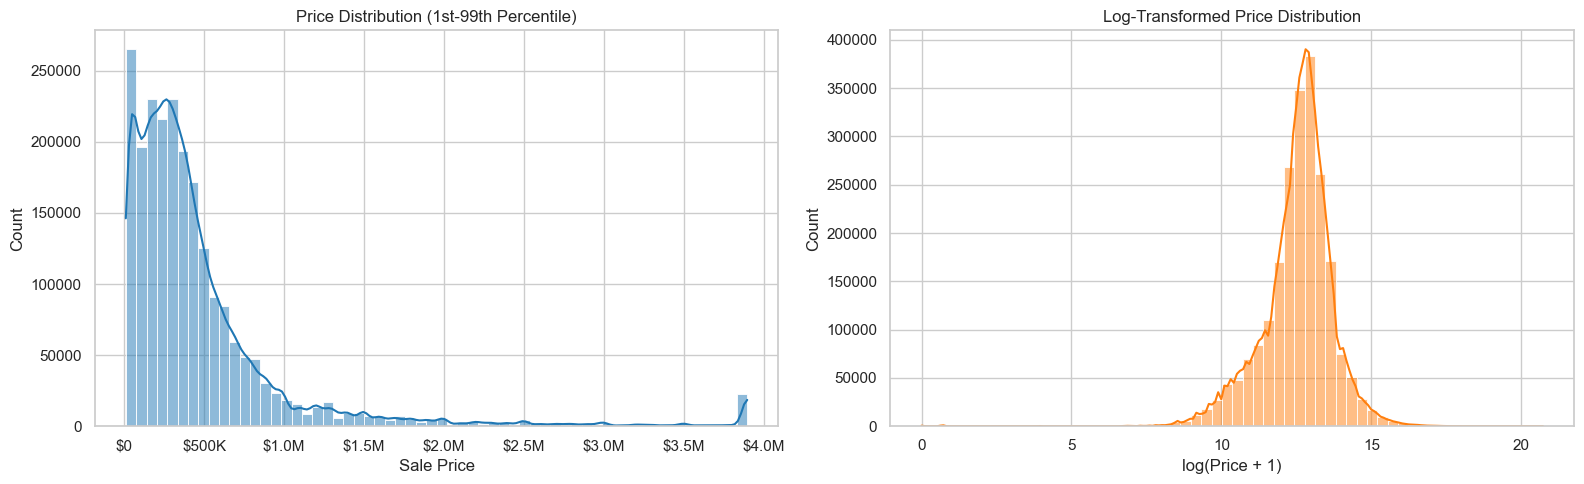

Skewness (raw): 229.29 | Skewness (log): -0.96


In [ ]:
price_series = processed_df[target_col].dropna()
trimmed_price = price_series.clip(lower=price_series.quantile(0.01), upper=price_series.quantile(0.99))
log_price = np.log1p(price_series)

fig, axes = plt.subplots(1, 2, figsize=(16, 5))

sns.histplot(trimmed_price, bins=60, kde=True, ax=axes[0], color="#1f77b4")
axes[0].set_title("Price Distribution (1st-99th Percentile)")
axes[0].set_xlabel("Sale Price")
axes[0].xaxis.set_major_formatter(FuncFormatter(currency_label))

sns.histplot(log_price, bins=60, kde=True, ax=axes[1], color="#ff7f0e")
axes[1].set_title("Log-Transformed Price Distribution")
axes[1].set_xlabel("log(Price + 1)")

plt.tight_layout()
plt.show()

print(
    f"Skewness (raw): {price_series.skew():.2f} | Skewness (log): {log_price.skew():.2f}"
)

### Step 6: Explore Relationships
Bedrooms, bathrooms, house size, and lot size are all right-skewed with noticeable spikes at round numbers (for example, a lot of 3-bed/2-bath homes). The heatmap uses Spearman correlation (handles skewed data better than Pearson), and the scatter plots let us see how each feature lines up with price. This satisfies the requirement to study correlations and discuss potential problems such as multicollinearity.

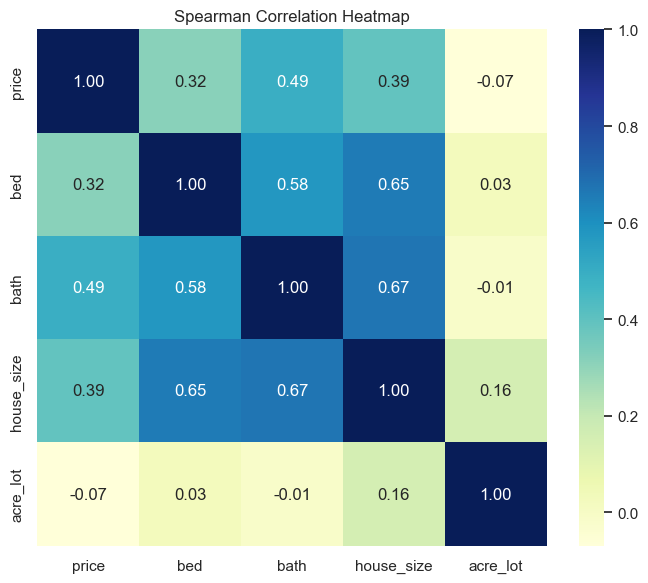

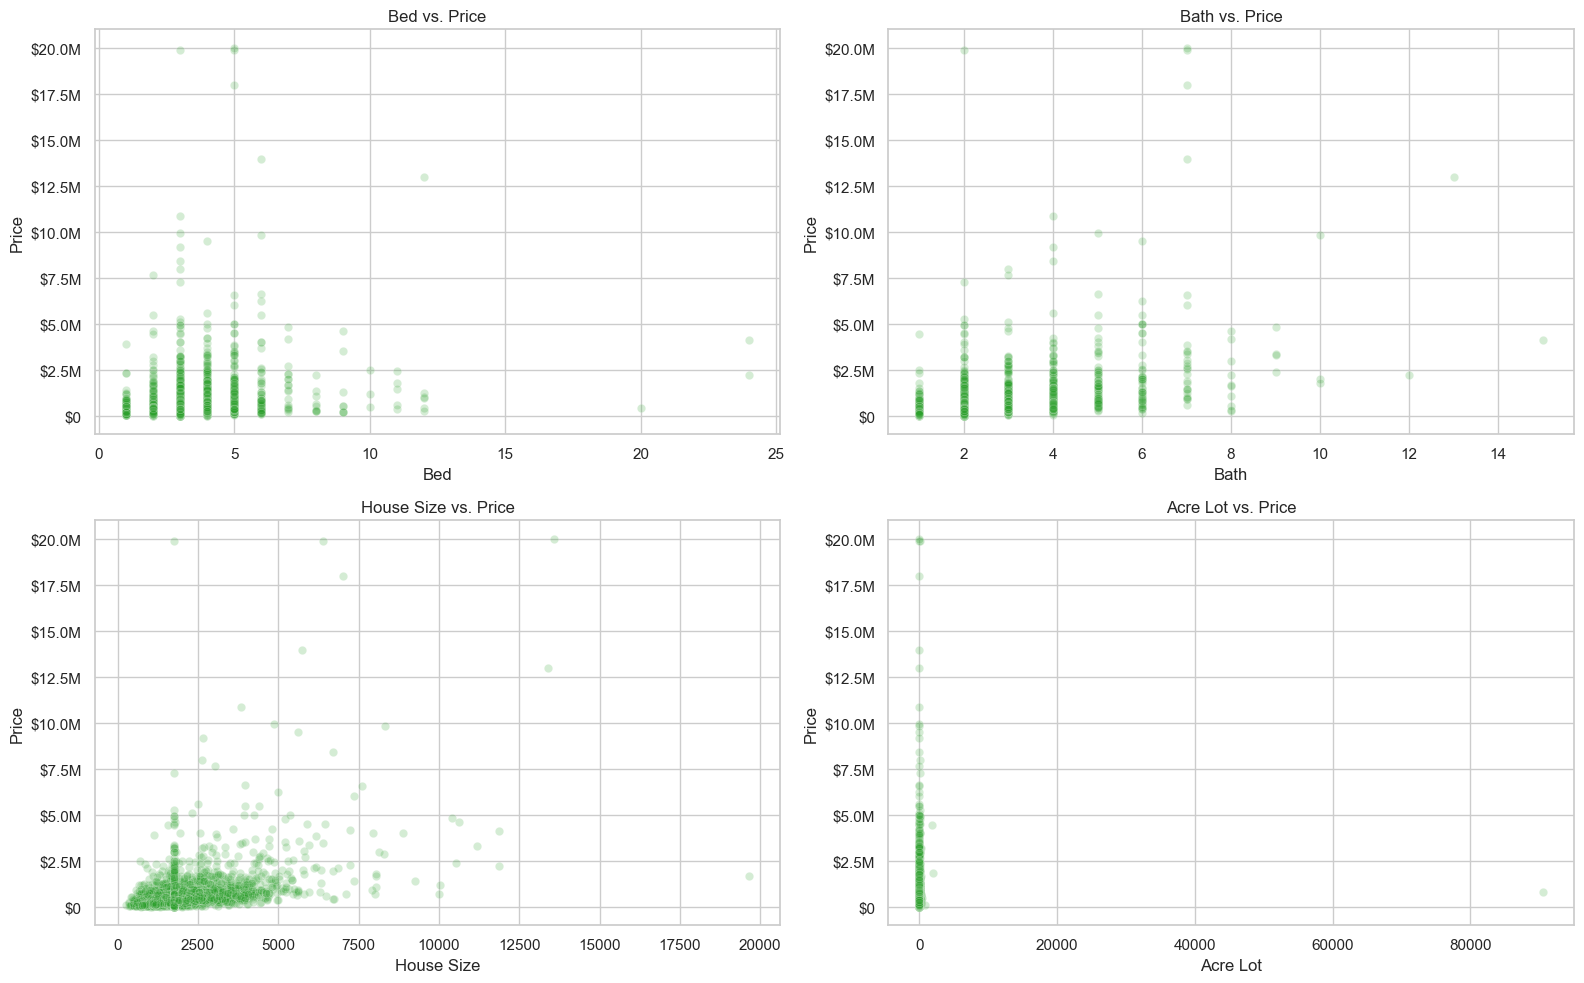

price         1.000000
bath          0.494609
house_size    0.393414
bed           0.315138
acre_lot     -0.068880
Name: price, dtype: float64

In [ ]:
analysis_cols = [target_col, "bed", "bath", "house_size", "acre_lot"]
plot_sample = processed_df[analysis_cols].dropna().sample(n=50000, random_state=42)

# Correlation heatmap
corr = plot_sample.corr(method="spearman")
fig, ax = plt.subplots(figsize=(7, 6))
sns.heatmap(corr, annot=True, fmt=".2f", cmap="YlGnBu", ax=ax)
ax.set_title("Spearman Correlation Heatmap")
plt.tight_layout()
plt.show()

# Scatter plots for each descriptive feature versus price
scatter_sample = plot_sample.sample(5000, random_state=24)
scatter_features = ["bed", "bath", "house_size", "acre_lot"]
fig, axes = plt.subplots(2, 2, figsize=(16, 10))
axes = axes.ravel()

for idx, feature in enumerate(scatter_features):
    sns.scatterplot(
        data=scatter_sample,
        x=feature,
        y=target_col,
        alpha=0.2,
        color="#2ca02c",
        ax=axes[idx],
    )
    axes[idx].set_ylabel("Price")
    axes[idx].yaxis.set_major_formatter(FuncFormatter(currency_label))
    axes[idx].set_xlabel(feature.replace("_", " ").title())
    axes[idx].set_title(f"{feature.replace('_', ' ').title()} vs. Price")

plt.tight_layout()
plt.show()

corr[target_col].sort_values(ascending=False)

### Step 7: Simple Feature Ideas
Even without advanced ML, a couple of simple derived fields help tell the story:
- `price_per_sqft`: puts price in the context of home size so we can compare homes from different markets.
- `is_new_construction`: flags listings marked `ready_to_build`, which often behave differently on price.
- `log_price`: keeps the original target but gives us a more balanced scale for charts or basic models.
The summary table and histograms below show how these new features behave.

In [ ]:
engineered_df = processed_df.copy()

engineered_df["price_per_sqft"] = engineered_df[target_col] / engineered_df["house_size"].replace(0, np.nan)
engineered_df["is_new_construction"] = (engineered_df["status"] == "ready_to_build").astype(int)
engineered_df["log_price"] = np.log1p(engineered_df[target_col])

feature_subset = engineered_df[["price_per_sqft", "is_new_construction", "log_price"]]
feature_subset.describe(percentiles=[0.25, 0.5, 0.75, 0.95]).T

,count,mean,std,min,25%,50%,75%,95%,max
price_per_sqft,2220444.0,260.733753,1818.289188,0.0,107.881351,180.454545,285.854026,720.551378,2.426535e+06
is_new_construction,2220444.0,0.011274,0.105578,0.0,0.000000,0.000000,0.000000,0.000000,1.000000e+00
log_price,2220444.0,12.547270,1.163848,0.0,12.013707,12.691584,13.217675,14.217637,2.148756e+01


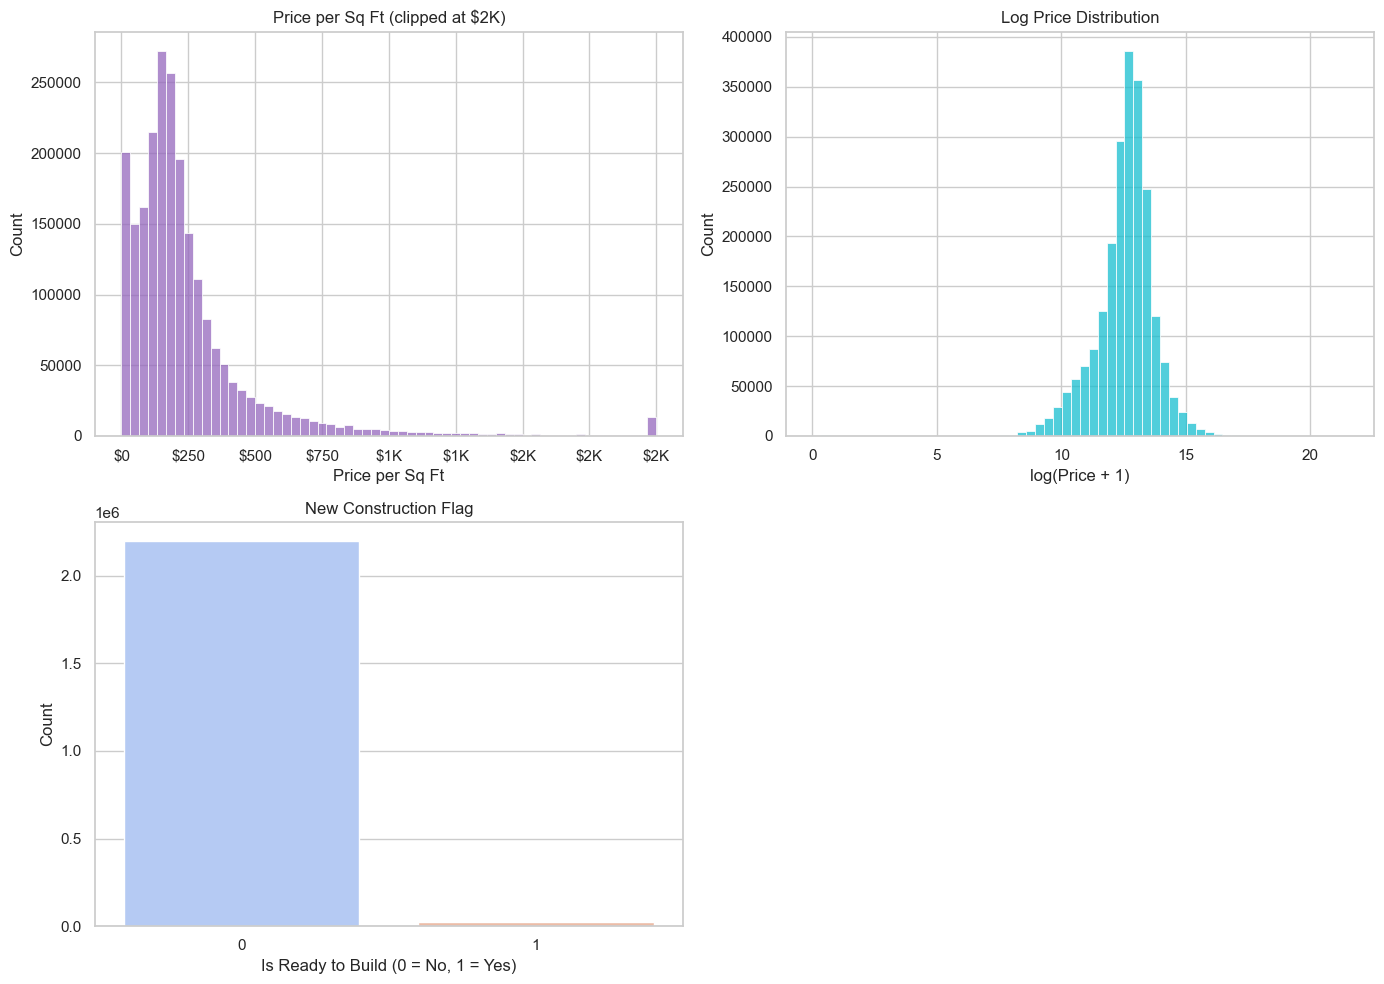

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

sns.histplot(engineered_df["price_per_sqft"].clip(0, 2000), bins=60, ax=axes[0, 0], color="#9467bd")
axes[0, 0].set_title("Price per Sq Ft (clipped at $2K)")
axes[0, 0].set_xlabel("Price per Sq Ft")
axes[0, 0].xaxis.set_major_formatter(FuncFormatter(currency_label))

sns.histplot(engineered_df["log_price"], bins=60, ax=axes[0, 1], color="#17becf")
axes[0, 1].set_title("Log Price Distribution")
axes[0, 1].set_xlabel("log(Price + 1)")

sns.countplot(
    data=engineered_df,
    x="is_new_construction",
    hue="is_new_construction",
    palette="coolwarm",
    ax=axes[1, 0]
)
axes[1, 0].set_title("New Construction Flag")
axes[1, 0].set_xlabel("Is Ready to Build (0 = No, 1 = Yes)")
axes[1, 0].set_ylabel("Count")
axes[1, 0].legend_.remove()

axes[1, 1].axis("off")

plt.tight_layout()
plt.show()

### Step 8: Reflect on the Process
1. **Understand the problem:** Confirmed the goal—make sense of the housing data and look for signals that explain price.
2. **Inspect the raw data:** Looked at column types, row counts, and missing values to spot quick fixes.
3. **Clean in small steps:** Filled missing values with simple medians or modes and kept dates/zip codes usable without over-complicating things.
4. **Explore visually:** Plotted price and feature distributions plus a small correlation heatmap to see what matters most.
5. **Add light features:** Created price-per-square-foot and a new-construction flag to highlight clear business stories.
6. **Next moves:** Compare cities or states in future steps, and try a simple regression once the course covers modeling.

In [ ]:
numeric_profile_cols = list(dict.fromkeys(numeric_to_plot + [target_col]))
numeric_profile = df[numeric_profile_cols].describe(percentiles=[0.25, 0.5, 0.75, 0.95, 0.99]).T
numeric_profile

,count,mean,std,min,25%,50%,75%,95%,99%,max
price,2224841.0,524195.519291,2.138893e+06,0.0,165000.00,325000.00,550000.00,1495000.00,3899000.00,2.147484e+09
bed,1745065.0,3.275841,1.567274e+00,1.0,3.00,3.00,4.00,5.00,7.00,4.730000e+02
bath,1714611.0,2.496440,1.652573e+00,1.0,2.00,2.00,3.00,4.00,6.00,8.300000e+02
acre_lot,1900793.0,15.223027,7.628238e+02,0.0,0.15,0.26,0.98,14.02,98.00,1.000000e+05
house_size,1657898.0,2714.471335,8.081635e+05,4.0,1300.00,1760.00,2413.00,4008.00,6439.03,1.040400e+09


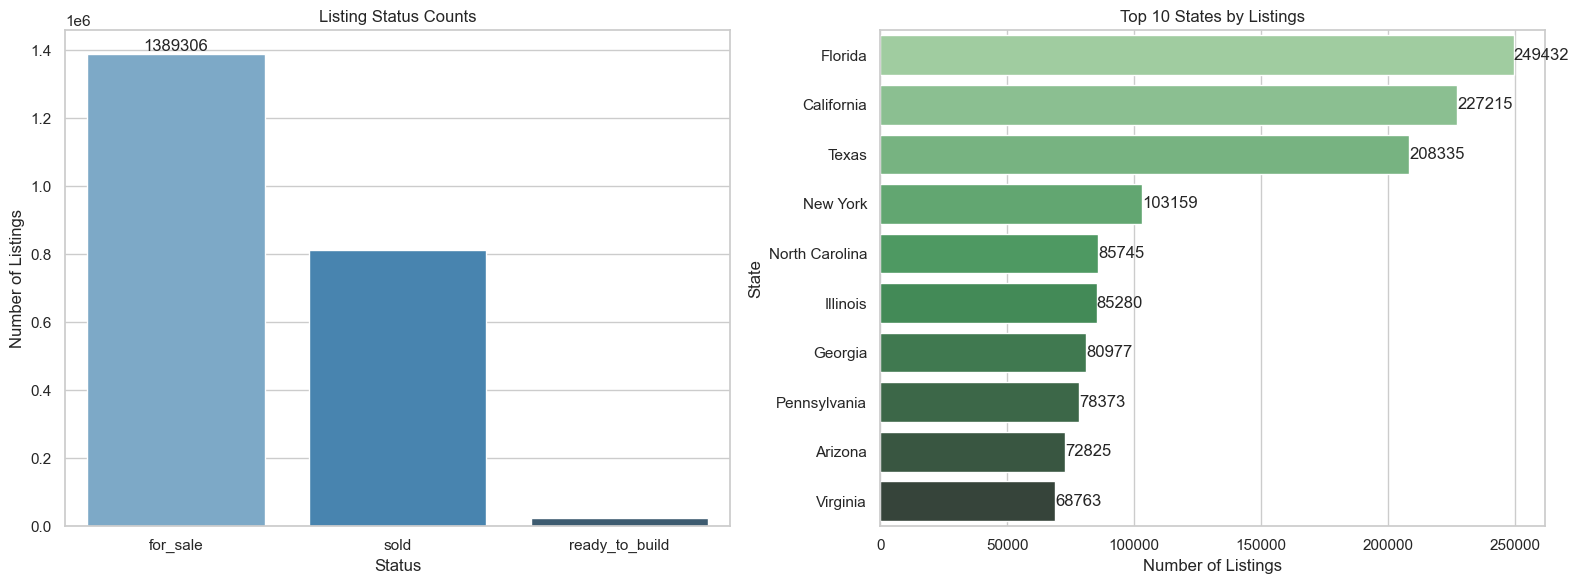

In [ ]:
fig, axes = plt.subplots(1, 2, figsize=(16, 6))
status_counts = df['status'].value_counts().reset_index()
status_counts.columns = ['status', 'count']
sns.barplot(data=status_counts, x='status', y='count', hue='status', ax=axes[0], palette='Blues_d', legend=False)
axes[0].set_title('Listing Status Counts')
axes[0].set_xlabel('Status')
axes[0].set_ylabel('Number of Listings')
axes[0].bar_label(axes[0].containers[0], fmt='%d')

top_states = df['state'].value_counts().head(10).reset_index()
top_states.columns = ['state', 'count']
sns.barplot(data=top_states, y='state', x='count', hue='state', ax=axes[1], palette='Greens_d', legend=False)
axes[1].set_title('Top 10 States by Listings')
axes[1].set_xlabel('Number of Listings')
axes[1].set_ylabel('State')
for container in axes[1].containers:
    axes[1].bar_label(container, fmt='%d')

plt.tight_layout()
plt.show()

In [ ]:
price_status_summary = (
    df.groupby('status')[target_col]
    .agg(['count', 'mean', 'median', 'std', 'min', 'max'])
    .round(2)
)
price_status_summary

,count,mean,median,std,min,max
status,,,,,,
for_sale,1388359,547862.54,305000.0,2639206.97,0.0,2.147484e+09
ready_to_build,24718,509278.88,454209.5,255127.35,0.0,4.900000e+06
sold,811764,484172.05,344900.0,788079.54,1.0,2.950000e+08


In [ ]:
def currency_label(value: float, _pos: int) -> str:
    """Format axis ticks using readable currency suffixes."""
    if value == 0:
        return "$0"
    abs_val = abs(value)
    if abs_val >= 1_000_000_000:
        return f"${value/1_000_000_000:.1f}B"
    if abs_val >= 1_000_000:
        return f"${value/1_000_000:.1f}M"
    if abs_val >= 1_000:
        return f"${value/1_000:.0f}K"
    return f"${value:,.0f}"